
# Floward Image Inspection Notebook

This notebook helps you inspect and visualize per-image diagnostics for Floward photography guidelines:

- Ivory background detection (LAB band)
- Object mask (non-ivory)
- Podium-to-object width ratio near the base
- Background LAB statistics excluding shadows
- Right-angle frame check (dominant edges near horizontal/vertical)
- Per-image metrics table and CSV export

Notes:
- Uses pure matplotlib (no seaborn), one chart per figure, and doesn't set explicit colors.
- Update `IMAGES_DIR` below to your image folder.
- Supported formats by default: `.jpg`, `.jpeg`, `.png`, `.webp`.


In [ ]:

import os, glob, math, json
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt

# ---- Configuration ----
IMAGES_DIR = "/mnt/c/Users/rahar/Documents/Sample_image"  # <-- CHANGE if needed
SAVE_CSV_TO = "./floward_inspection_results.csv"          # output CSV path
MAX_IMAGES = 12                                           # limit for preview/plots

# Ivory (LAB) target band (expand/shrink as you validate on real data)
IVORY_L = (88, 92)
IVORY_A = (-1, 3)
IVORY_B = (8, 12)

# Podium:object width ratio band (~0.75 ideal)
PODIUM_OBJ_RATIO_OK = (0.6, 0.9)

# Target canvas size
TARGET_W, TARGET_H = 1000, 1000

VALID_EXTS = (".jpg", ".jpeg", ".png", ".webp")


In [ ]:

def list_images(root, max_n=None):
    paths = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith(VALID_EXTS):
                paths.append(os.path.join(r, f))
    paths.sort()
    return paths[:max_n] if max_n else paths

def load_rgb(path):
    """Robust image loader; handles BGR, GRAY, and RGBA -> RGB on white background."""
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise RuntimeError(f"Cannot read {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA
        alpha = img[:, :, 3] / 255.0
        bg = np.ones_like(img[:, :, :3]) * 255
        img = (img[:, :, :3] * alpha[..., None] + bg * (1 - alpha[..., None])).astype(np.uint8)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def rgb_to_lab(img_rgb):
    return color.rgb2lab(img_rgb.astype(np.float32) / 255.0)

def ivory_background_mask(img_rgb):
    """Binary mask where pixels fall within an expanded ivory LAB tolerance band."""
    lab = rgb_to_lab(img_rgb)
    L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]
    m = (
        (L >= IVORY_L[0]-6) & (L <= IVORY_L[1]+6) &
        (A >= IVORY_A[0]-6) & (A <= IVORY_A[1]+6) &
        (B >= IVORY_B[0]-8) & (B <= IVORY_B[1]+8)
    ).astype(np.uint8)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  np.ones((5,5), np.uint8))
    return m

def largest_component(mask):
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num <= 1:
        return None, None
    idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    comp = (labels == idx).astype(np.uint8)
    return comp, stats[idx]  # (x,y,w,h,area)

def compute_object_mask(img_rgb):
    """Object = not-ivory (heuristic). Returns mask and bbox (x,y,w,h,area)."""
    bg = ivory_background_mask(img_rgb)
    obj = (1 - bg).astype(np.uint8)
    obj = cv2.morphologyEx(obj, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    obj = cv2.morphologyEx(obj, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    comp, bbox = largest_component(obj)
    if comp is None:
        return np.zeros(obj.shape, np.uint8), None
    return comp, bbox

def podium_width_ratio(img_rgb, obj_mask):
    """Heuristic: find widest near-ivory component in bottom 35% as podium; compare to object base width."""
    H, W, _ = img_rgb.shape
    bg = ivory_background_mask(img_rgb)
    cand = bg.copy()
    cand[:int(H*0.65), :] = 0
    cand = cv2.morphologyEx(cand, cv2.MORPH_OPEN, np.ones((3,25), np.uint8))
    comp, bbox = largest_component(cand)
    if comp is None:
        return None
    px, py, pw, ph, _ = bbox
    _, obox = largest_component(obj_mask)
    if obox is None:
        return None
    ox, oy, ow, oh, _ = obox
    band_top = oy + int(oh*0.8)
    band = obj_mask[band_top:oy+oh, :]
    if band.size == 0:
        return None
    cols = np.where(band.sum(axis=0) > 0)[0]
    if cols.size == 0:
        return None
    obj_base_w = cols[-1] - cols[0] + 1
    return float(obj_base_w) / float(pw) if pw > 0 else None

def background_stats_without_object(img_rgb, obj_mask):
    """Mean LAB of background excluding deep shadows (L < mean - 2*std)."""
    inv = (1 - obj_mask).astype(np.uint8)
    lab = rgb_to_lab(img_rgb)
    L, A, B = lab[:,:,0], lab[:,:,1], lab[:,:,2]
    Lbg = L[inv==1]
    if Lbg.size == 0:
        return None
    meanL, stdL = np.mean(Lbg), np.std(Lbg)
    shadow = (inv==1) & (L < (meanL - 2*stdL))
    bg_mask = inv.copy(); bg_mask[shadow] = 0
    if bg_mask.sum() == 0:
        bg_mask = inv
    return {
        'mean_L_bg': float(np.mean(L[bg_mask==1])),
        'mean_a_bg': float(np.mean(A[bg_mask==1])),
        'mean_b_bg': float(np.mean(B[bg_mask==1])),
        'bg_mask': bg_mask
    }

def right_angle_frame_check(img_rgb, tol_deg=3.0):
    """Check that most prominent lines are near 0 deg or 90 deg (within tol)."""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 80, 160)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=120,
                            minLineLength=gray.shape[1]//4, maxLineGap=20)
    if lines is None:
        return False
    ok, total = 0, 0
    for ln in lines[:50]:
        x1,y1,x2,y2 = ln[0]
        ang = abs(math.degrees(math.atan2(y2-y1, x2-x1)))
        ang = min(ang, 180-ang)
        total += 1
        if abs(ang-0)<=tol_deg or abs(ang-90)<=tol_deg:
            ok += 1
    return (total > 0 and ok/total >= 0.7)

def evaluate_image(path, obj_cov_target=0.75, ratio_band=PODIUM_OBJ_RATIO_OK):
    img = load_rgb(path)
    H, W, _ = img.shape
    dims_ok = (H == TARGET_H and W == TARGET_W)

    obj_mask, _ = compute_object_mask(img)
    obj_cov = float(obj_mask.sum()) / float(H*W)

    bg_stats = background_stats_without_object(img, obj_mask)
    if bg_stats is None:
        bg_mean_L = np.nan; bg_mean_a = np.nan; bg_mean_b = np.nan
        bg_mask = np.zeros((H,W), np.uint8)
    else:
        bg_mean_L = bg_stats['mean_L_bg']
        bg_mean_a = bg_stats['mean_a_bg']
        bg_mean_b = bg_stats['mean_b_bg']
        bg_mask = bg_stats['bg_mask']

    ivory_ok = (IVORY_L[0] <= bg_mean_L <= IVORY_L[1] and
                IVORY_A[0] <= bg_mean_a <= IVORY_A[1] and
                IVORY_B[0] <= bg_mean_b <= IVORY_B[1]) if not np.isnan(bg_mean_L) else False
    warmth_ok = (bg_mean_b >= 8.0) if not np.isnan(bg_mean_b) else False

    ratio = podium_width_ratio(img, obj_mask)
    ratio_ok = (ratio is not None and ratio_band[0] <= ratio <= ratio_band[1])
    frame_ok = right_angle_frame_check(img)

    recs = []
    if not dims_ok: recs.append("Resize to 1000x1000.")
    if not (obj_cov_target*0.9 <= obj_cov <= obj_cov_target*1.1):
        recs.append(f"Adjust object coverage to ~{int(obj_cov_target*100)}% (current {int(obj_cov*100)}%).")
    if not ratio_ok: recs.append("Fix podium alignment (object base ~75% of podium).")
    if not ivory_ok: recs.append("Normalize background to ivory (L approx 90, a approx 1, b approx 10).")
    if not warmth_ok: recs.append("Increase warmth (raise b channel).")
    if not frame_ok: recs.append("Correct perspective to right angles.")

    record = {
        'img_file': os.path.basename(path),
        'path': path,
        'img_H': H, 'img_W': W, 'dims_ok': dims_ok,
        'object_coverage': obj_cov,
        'podium_object_ratio': (np.nan if ratio is None else ratio),
        'ratio_ok': ratio_ok,
        'bg_mean_L': bg_mean_L,
        'bg_mean_a': bg_mean_a,
        'bg_mean_b': bg_mean_b,
        'ivory_ok': ivory_ok,
        'warmth_ok': warmth_ok,
        'frame_ok': frame_ok,
        'floward_prompt': " ".join(recs) if recs else "OK"
    }
    return img, obj_mask, bg_mask, record



## Preview & Visualize

- Lists up to `MAX_IMAGES` from `IMAGES_DIR`
- For each image:
  - Compute background (ivory) mask and object mask
  - Show: original image, background mask, object mask
  - Plot histograms for background L, a, b (one chart per figure)
  - Print derived metrics
- Save a summary CSV at `SAVE_CSV_TO`



=== 12685_370533.jpg ===
img_W: 450
img_H: 450
dims_ok: False
object_coverage: 0.999446913580247
podium_object_ratio: nan
bg_mean_L: 95.10809326171875
bg_mean_a: -0.31224972009658813
bg_mean_b: 1.3536336421966553
ivory_ok: False
warmth_ok: False
frame_ok: True
Prompt: Resize to 1000x1000. Adjust object coverage to ~75% (current 99%). Fix podium alignment (object base ~75% of podium). Normalize background to ivory (L approx 90, a approx 1, b approx 10). Increase warmth (raise b channel).

=== 15342_480234.jpg ===
img_W: 800
img_H: 1000
dims_ok: False
object_coverage: 0.923165
podium_object_ratio: 10.81081081081081
bg_mean_L: 97.59989929199219
bg_mean_a: 0.28997623920440674
bg_mean_b: 1.0303354263305664
ivory_ok: False
warmth_ok: False
frame_ok: False
Prompt: Resize to 1000x1000. Adjust object coverage to ~75% (current 92%). Fix podium alignment (object base ~75% of podium). Normalize background to ivory (L approx 90, a approx 1, b approx 10). Increase warmth (raise b channel). Correct 

/tmp/ipykernel_742/1673704984.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()



=== 17052_266771.jpg ===
img_W: 1000
img_H: 1000
dims_ok: True
object_coverage: 0.285776
podium_object_ratio: 0.869
bg_mean_L: 97.29679107666016
bg_mean_a: -0.050736140459775925
bg_mean_b: 0.41388291120529175
ivory_ok: False
warmth_ok: False
frame_ok: False
Prompt: Adjust object coverage to ~75% (current 28%). Normalize background to ivory (L approx 90, a approx 1, b approx 10). Increase warmth (raise b channel). Correct perspective to right angles.

=== 17052_266772.jpg ===
img_W: 1000
img_H: 1000
dims_ok: True
object_coverage: 0.303064
podium_object_ratio: 0.2896341463414634
bg_mean_L: 96.42035675048828
bg_mean_a: -0.03372270613908768
bg_mean_b: 0.1375168114900589
ivory_ok: False
warmth_ok: False
frame_ok: False
Prompt: Adjust object coverage to ~75% (current 30%). Fix podium alignment (object base ~75% of podium). Normalize background to ivory (L approx 90, a approx 1, b approx 10). Increase warmth (raise b channel). Correct perspective to right angles.

=== 17052_266773.jpg ===
im

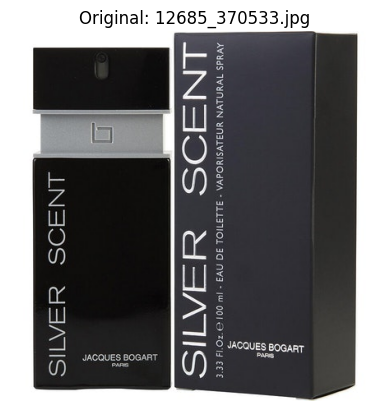

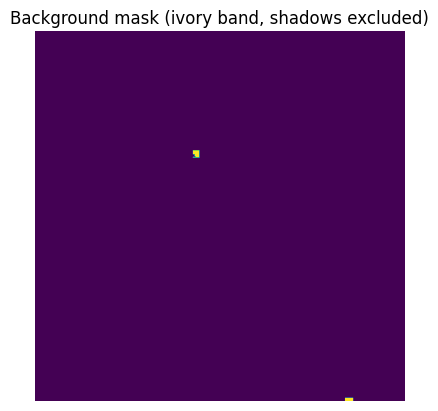

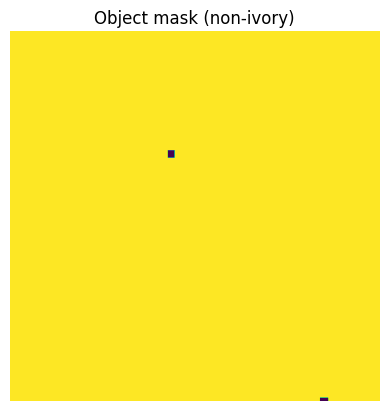

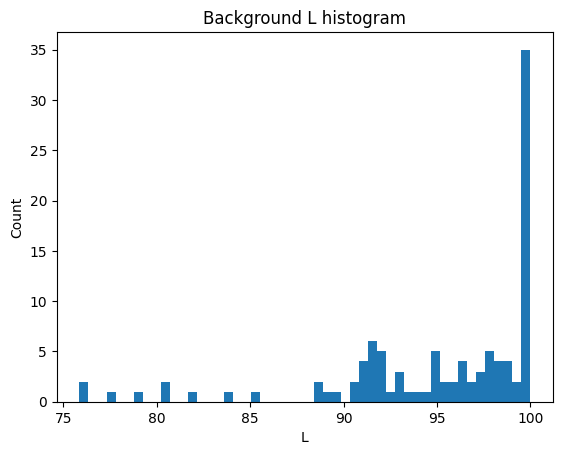

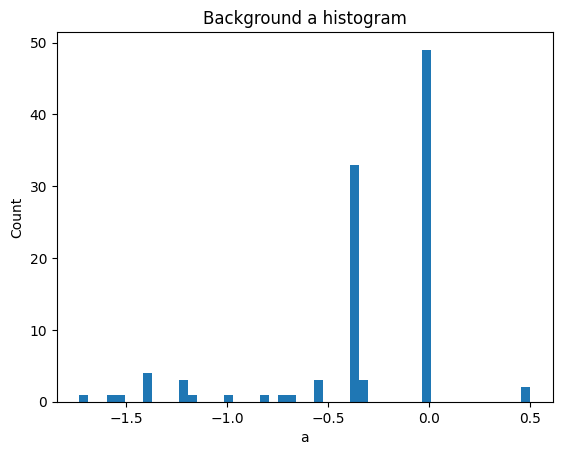

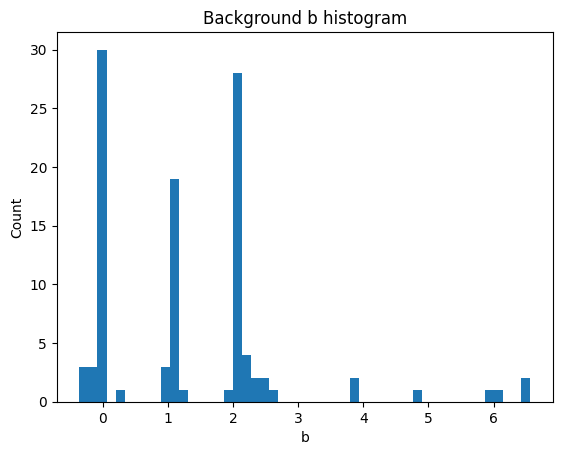

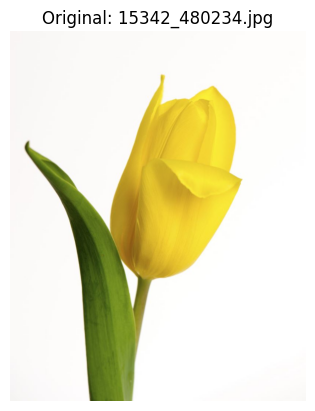

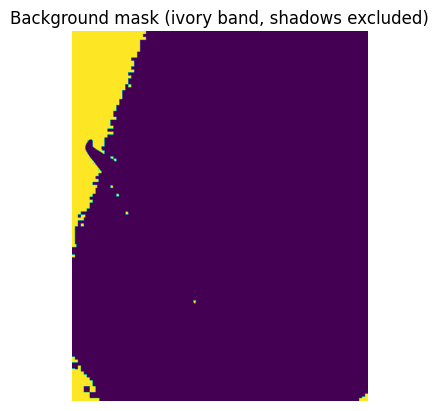

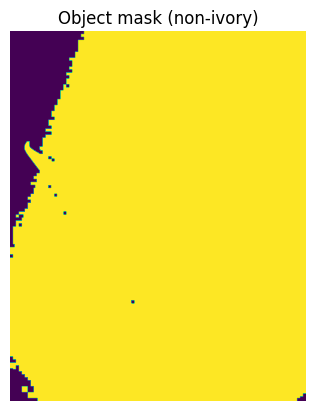

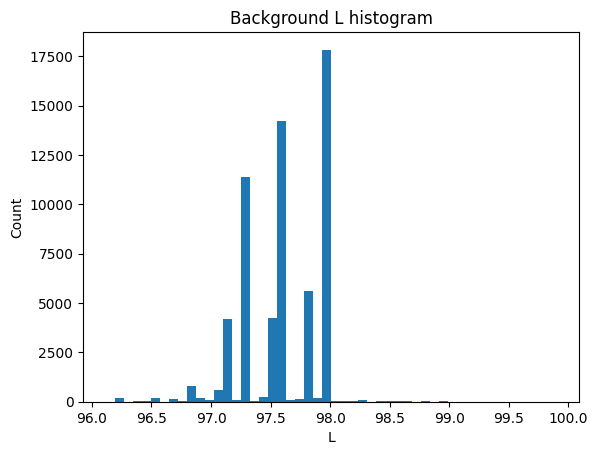

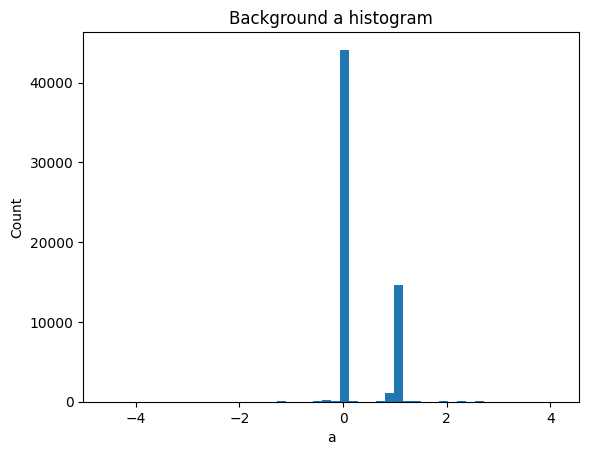

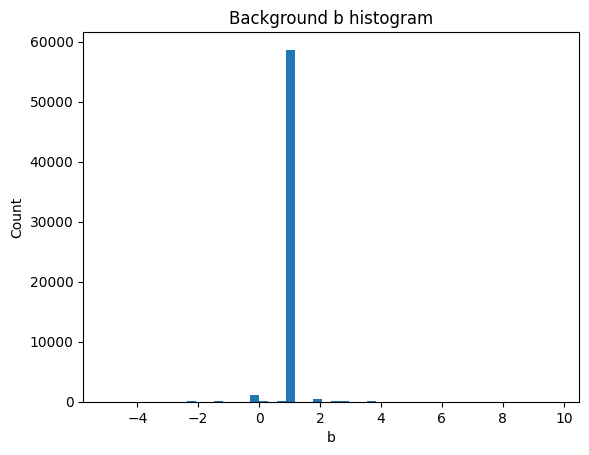

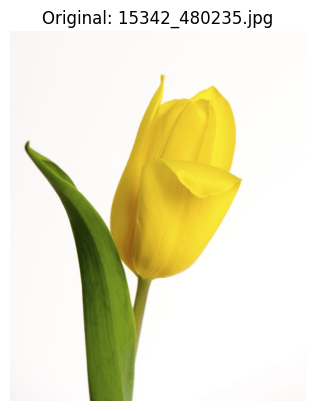

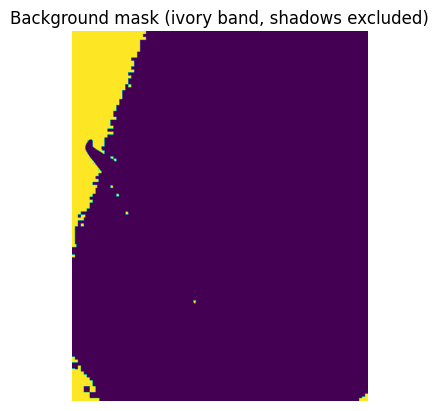

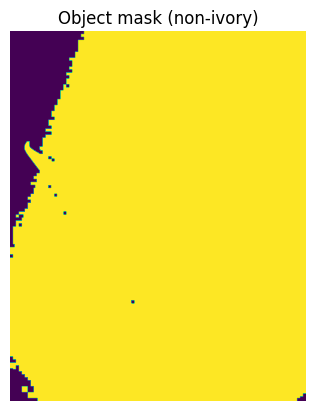

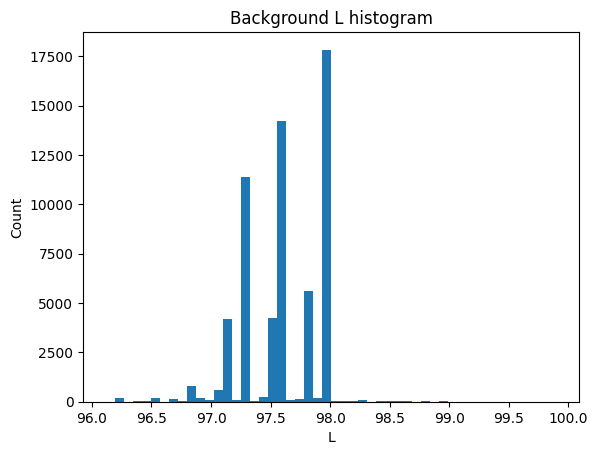

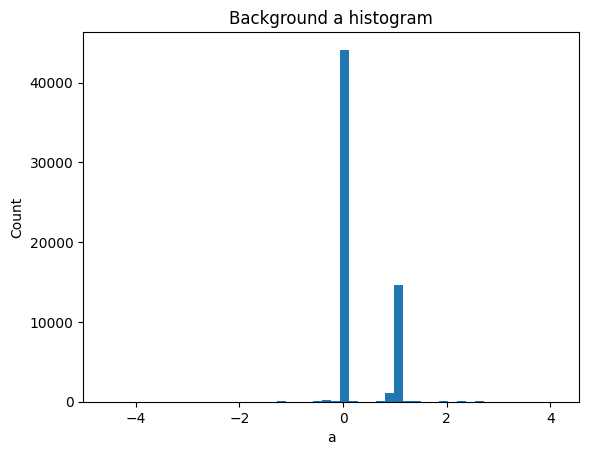

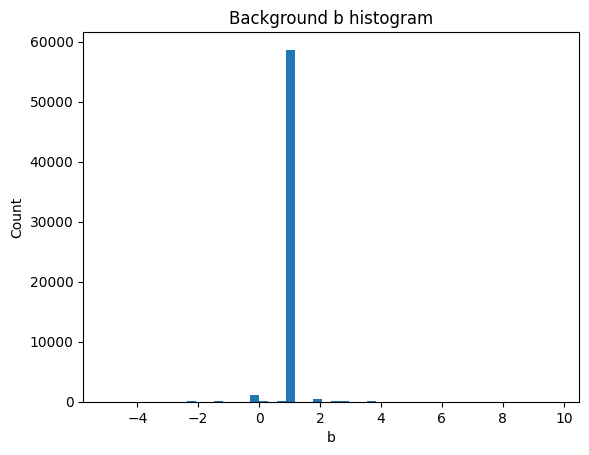

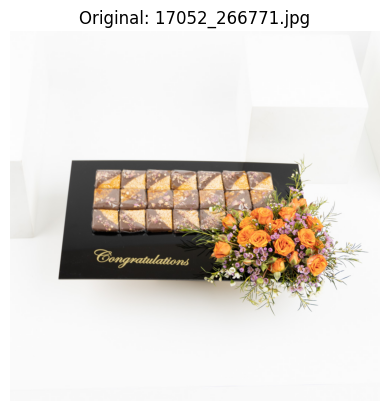

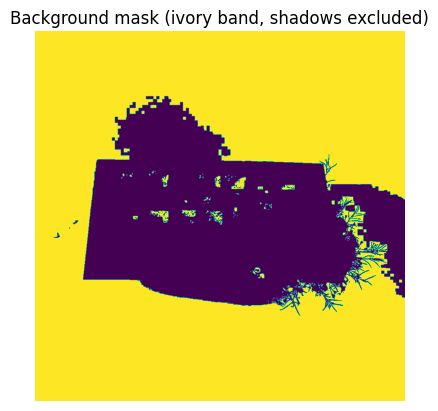

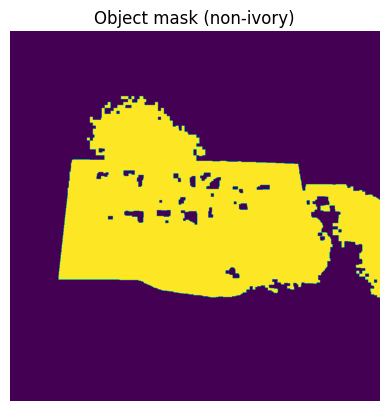

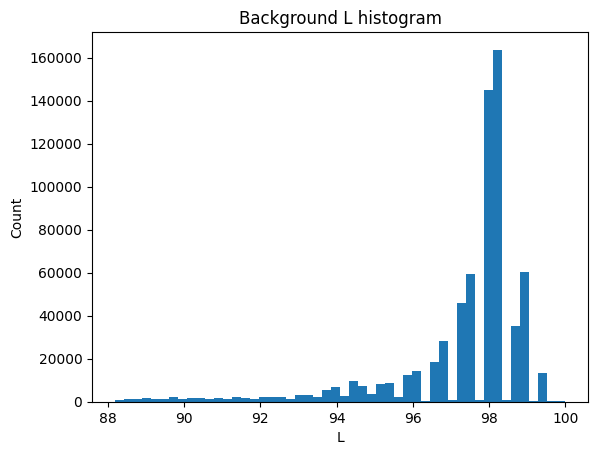

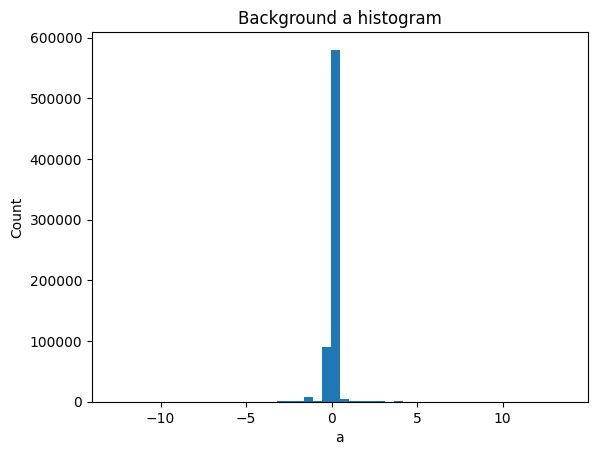

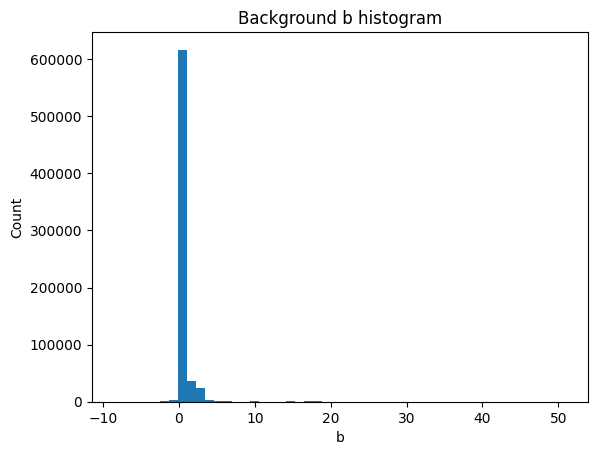

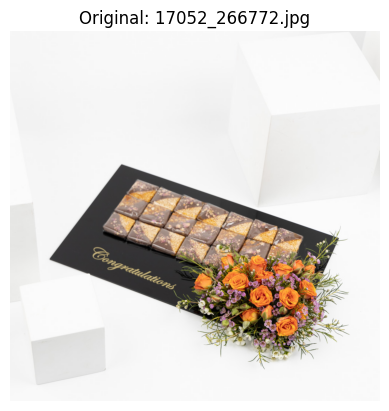

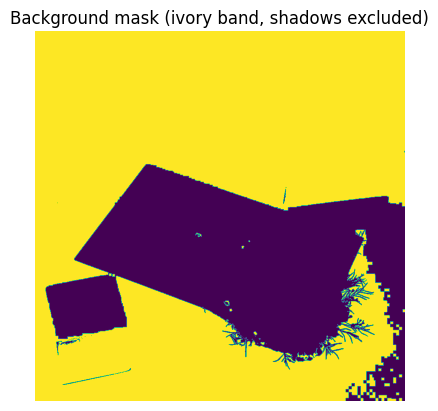

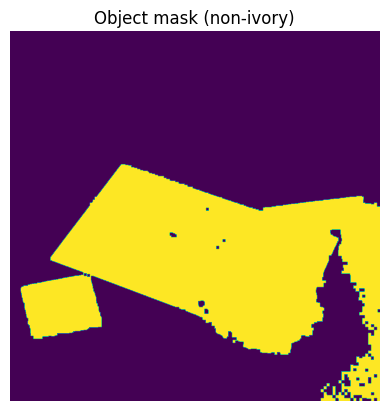

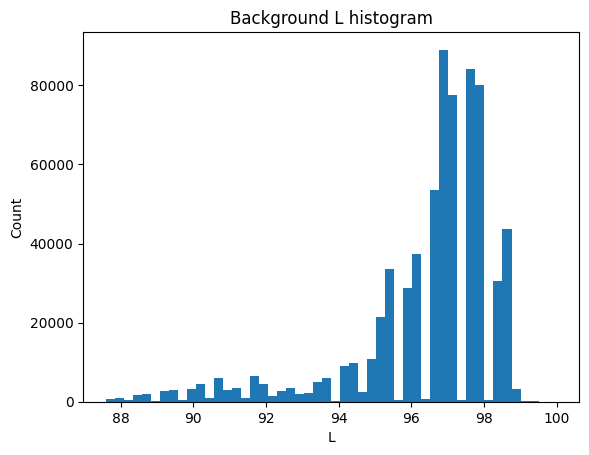

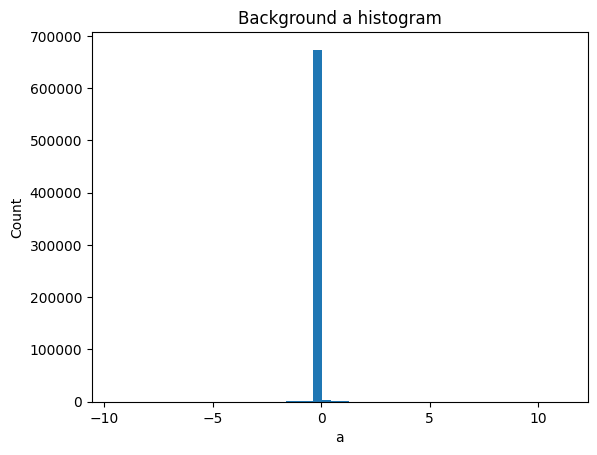

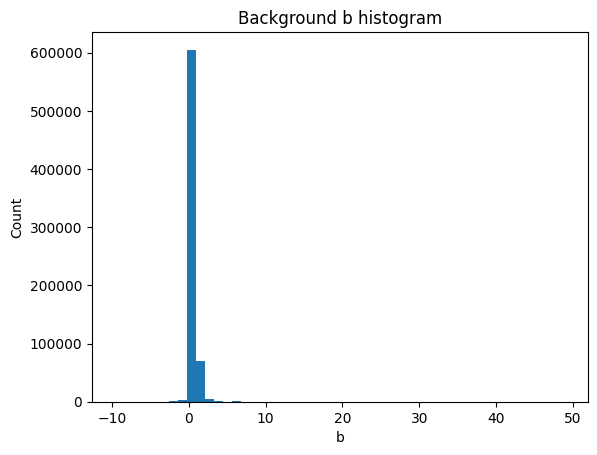

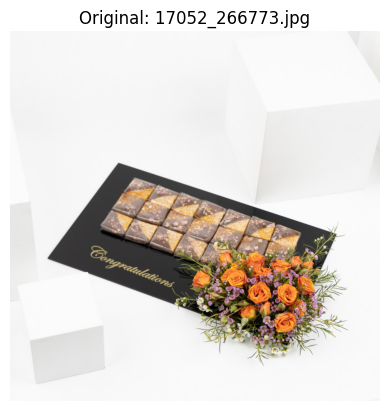

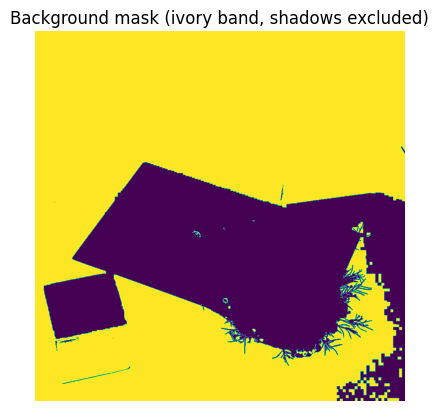

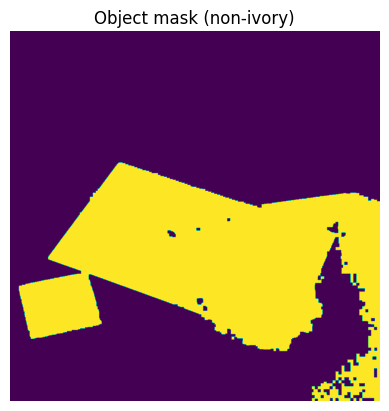

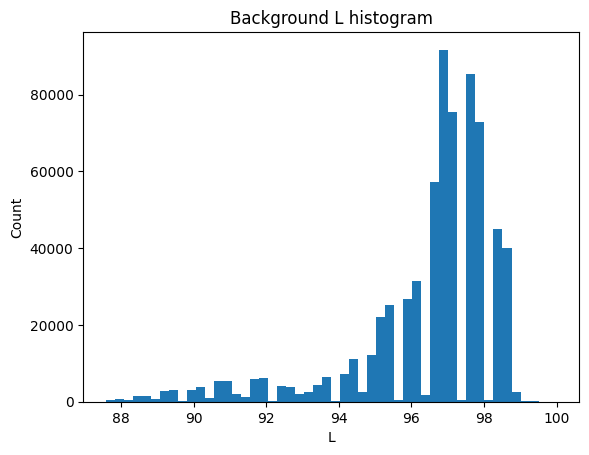

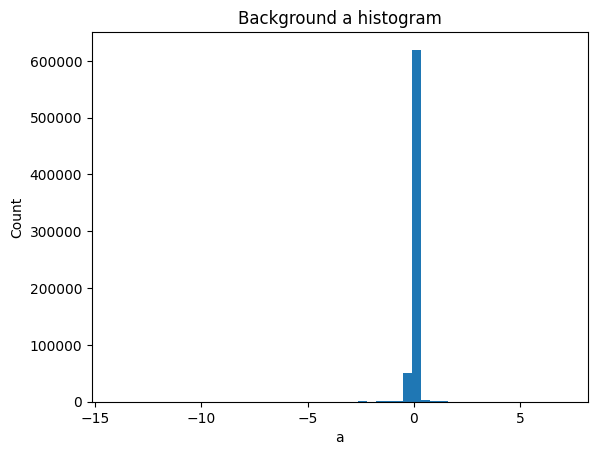

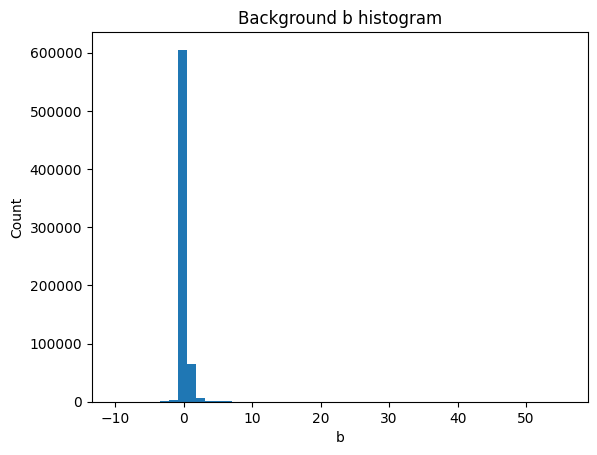

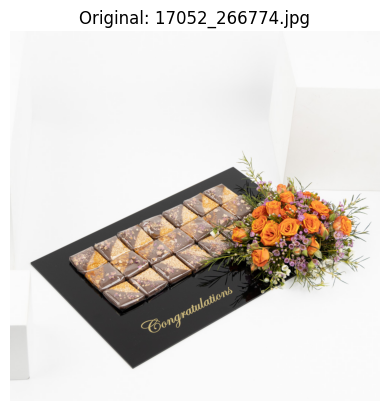

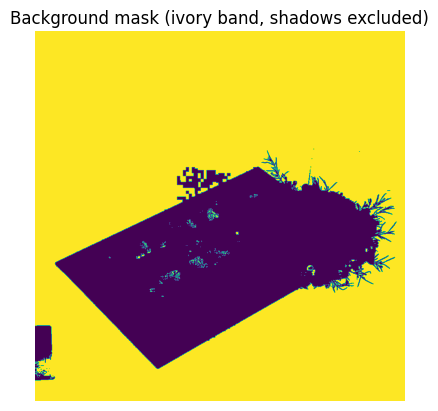

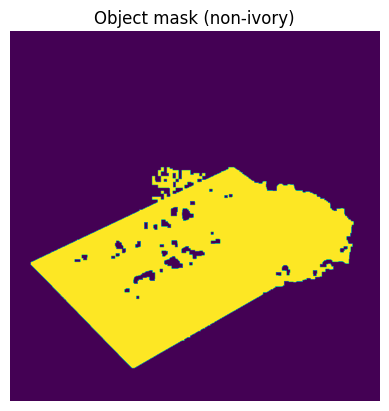

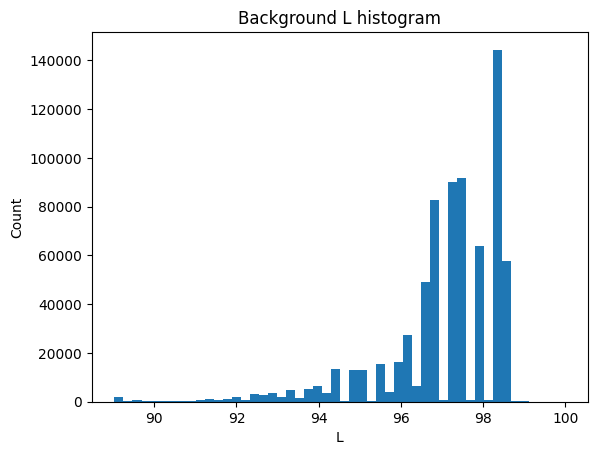

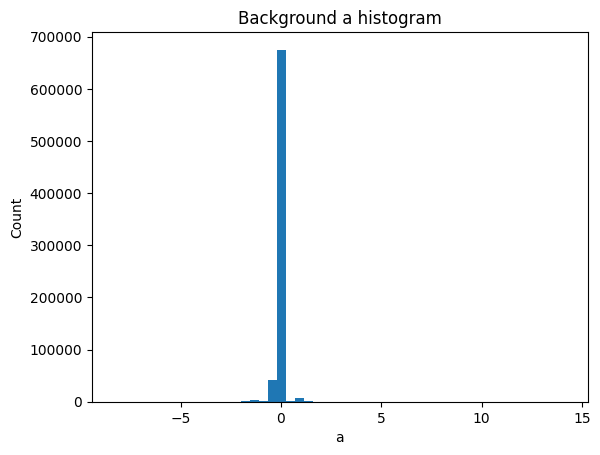

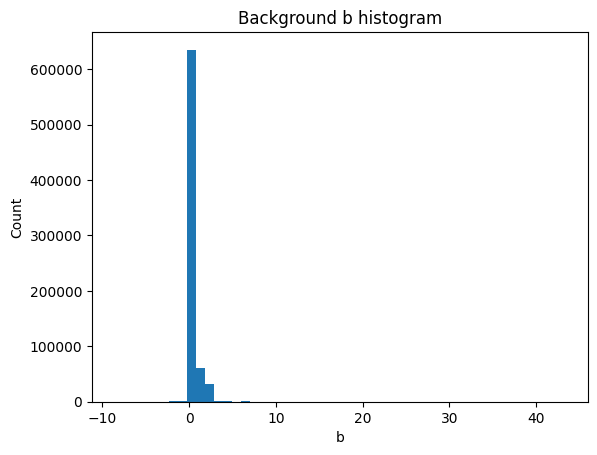

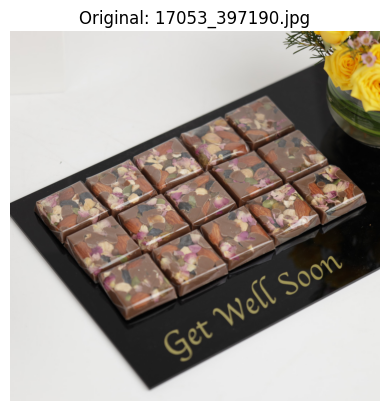

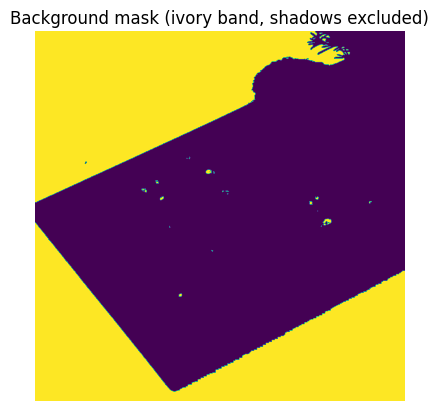

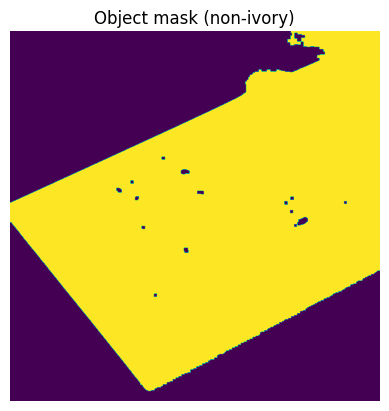

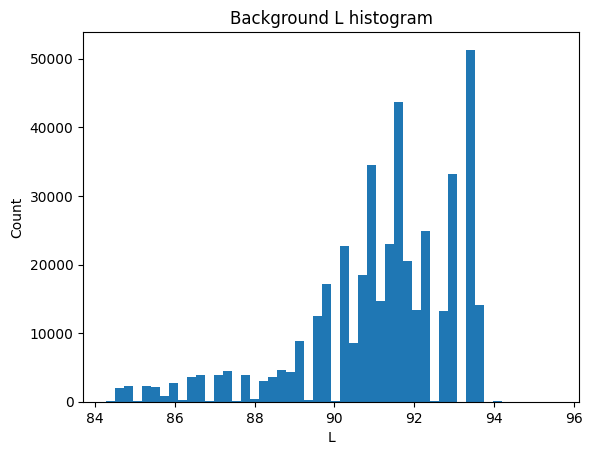

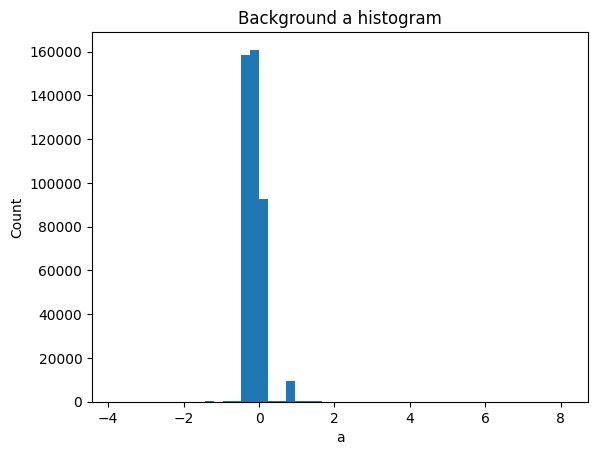

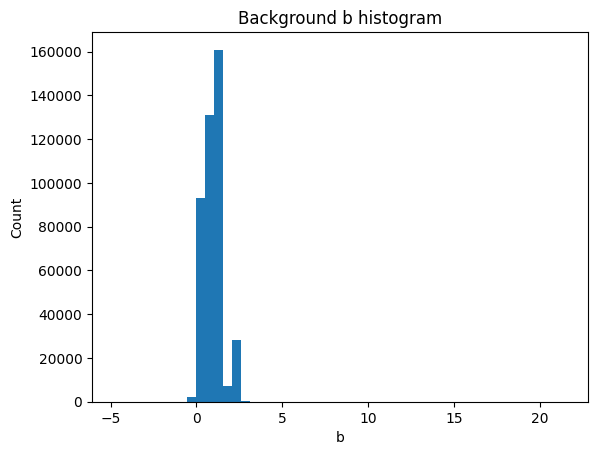

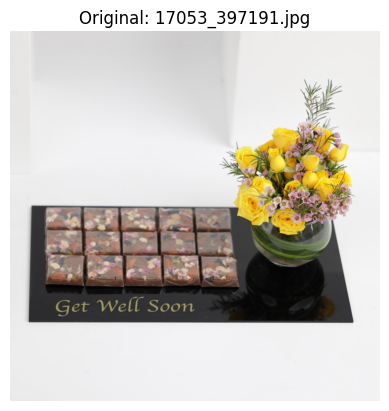

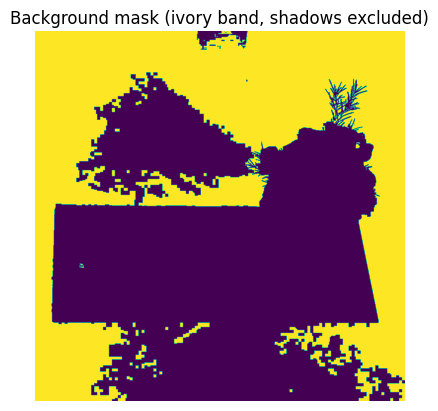

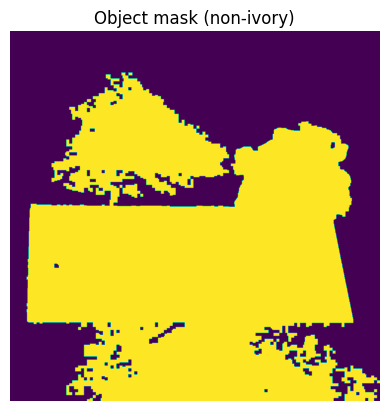

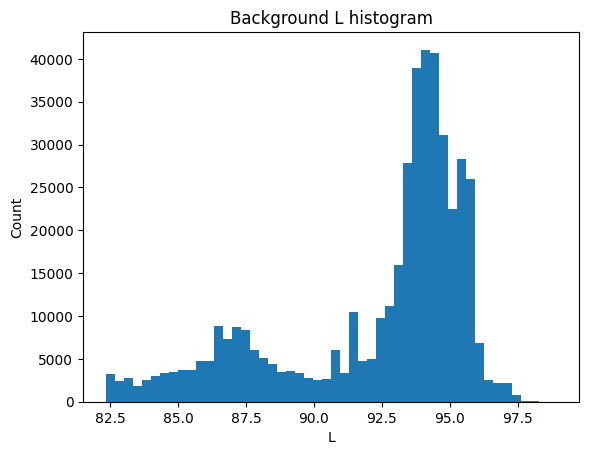

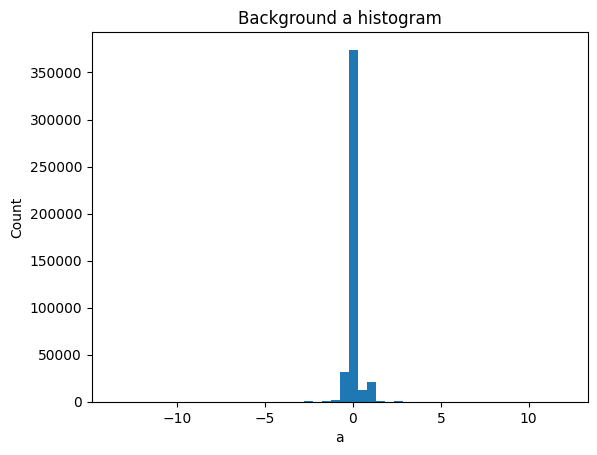

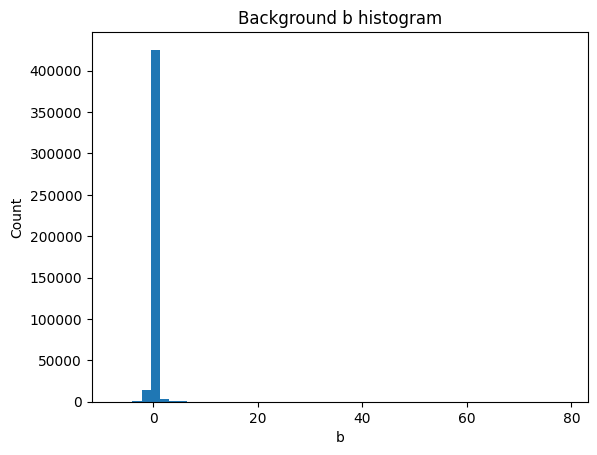

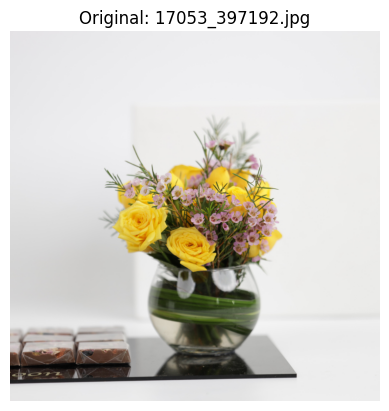

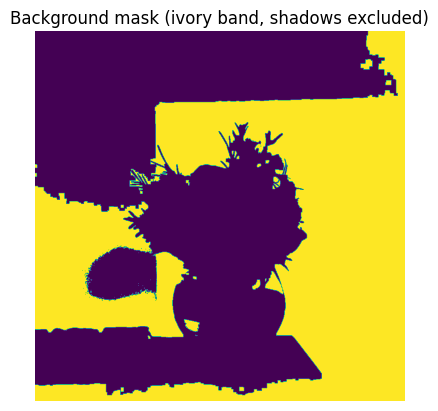

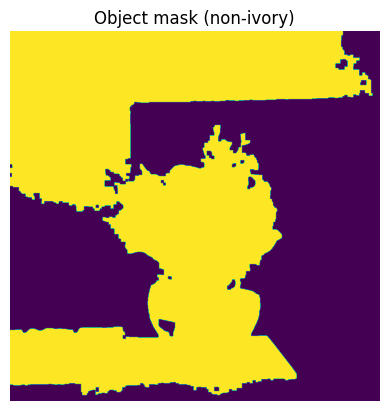

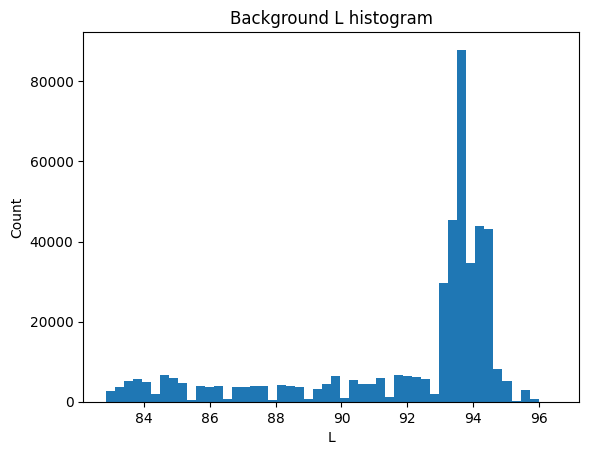

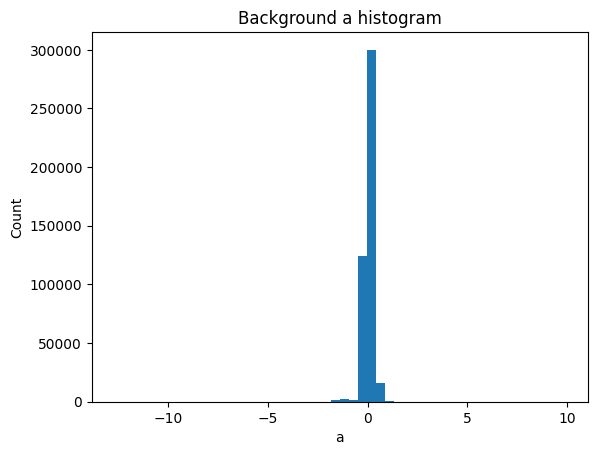

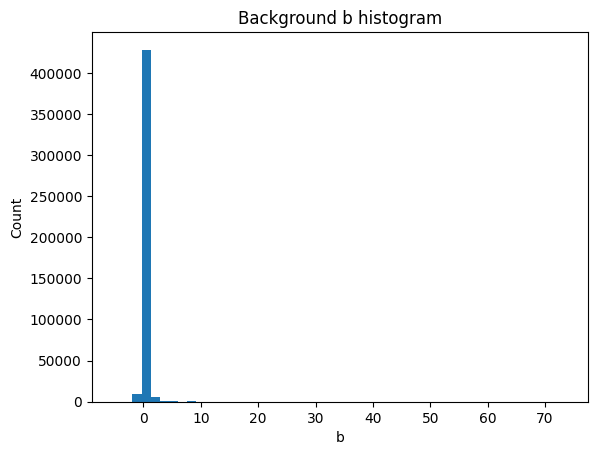

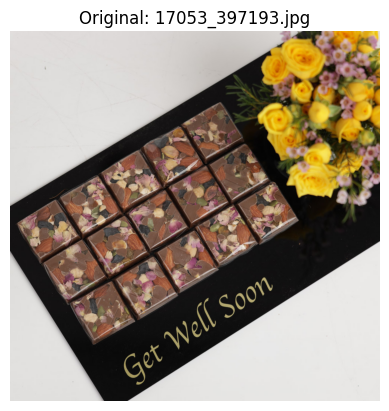

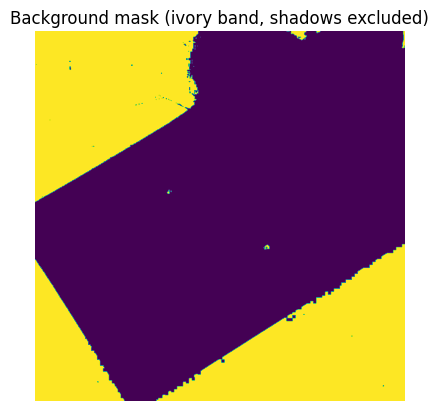

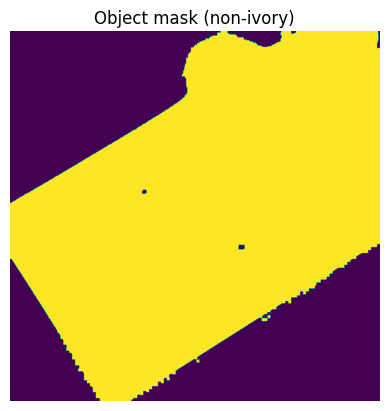

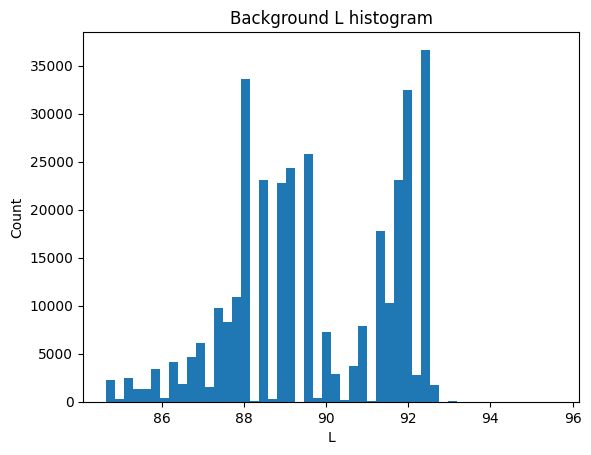

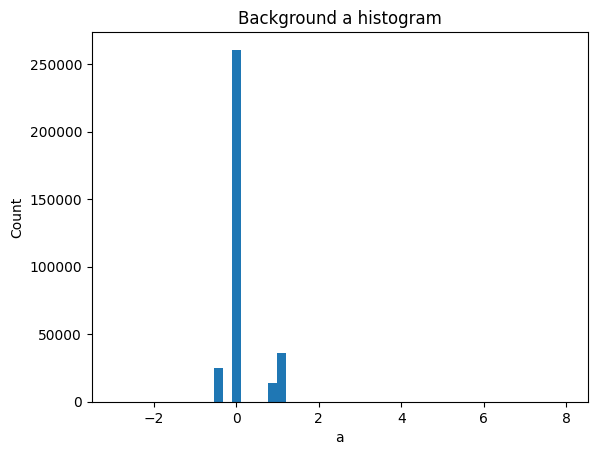

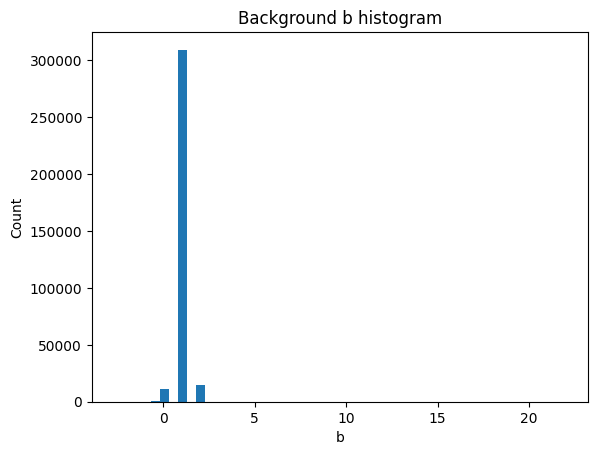

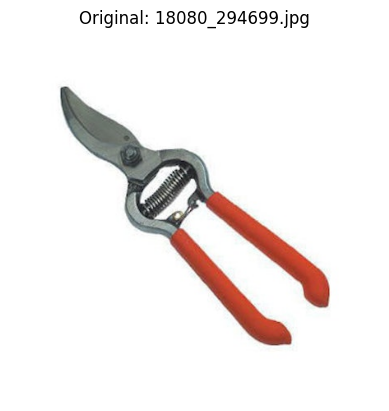

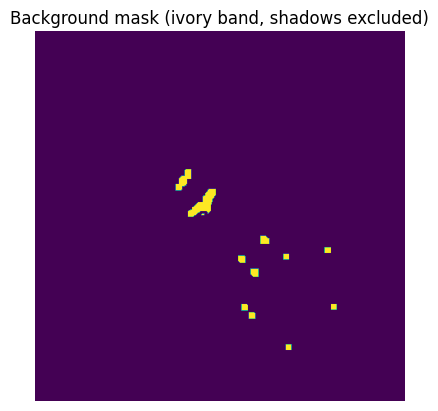

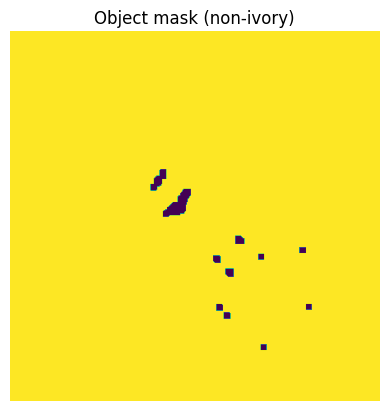

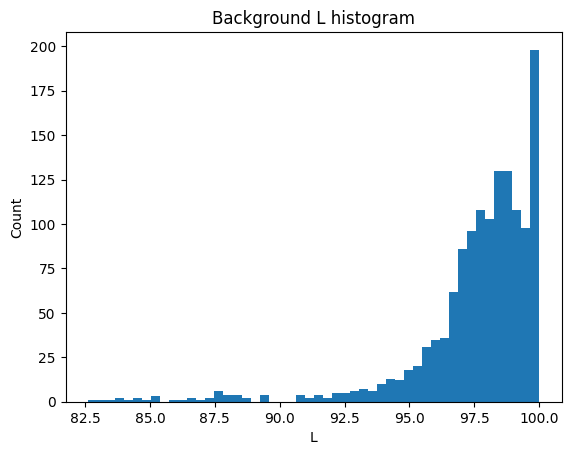

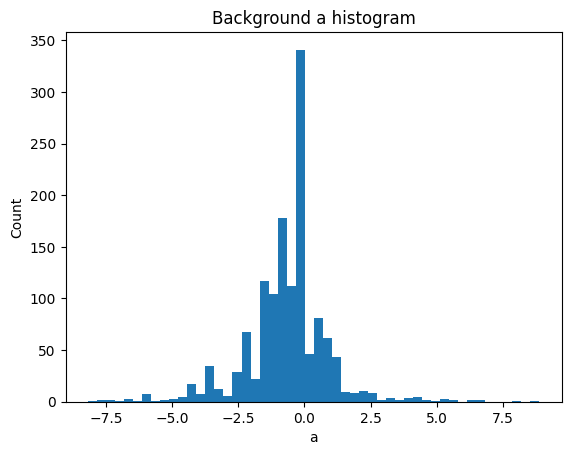

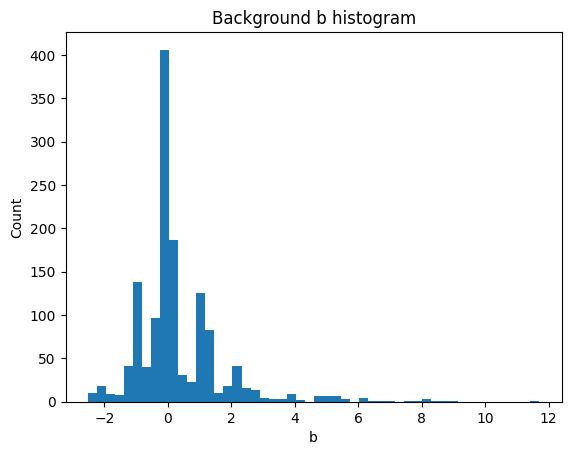

In [ ]:

paths = list_images(IMAGES_DIR, MAX_IMAGES)
if not paths:
    raise SystemExit(f"No images found in {IMAGES_DIR}. Update IMAGES_DIR above.")

records = []
for p in paths:
    try:
        img, obj_mask, bg_mask, rec = evaluate_image(p)
        records.append(rec)

        # Original
        plt.figure()
        plt.imshow(img)
        plt.title(f"Original: {rec['img_file']}")
        plt.axis('off')

        # Background mask
        plt.figure()
        plt.imshow(bg_mask)
        plt.title("Background mask (ivory band, shadows excluded)")
        plt.axis('off')

        # Object mask
        plt.figure()
        plt.imshow(obj_mask)
        plt.title("Object mask (non-ivory)")
        plt.axis('off')

        # Background L histogram
        lab = color.rgb2lab(img.astype(np.float32)/255.0)
        L = lab[:,:,0][bg_mask==1]
        if L.size > 0:
            plt.figure()
            plt.hist(L.flatten(), bins=50)
            plt.title("Background L histogram")
            plt.xlabel("L")
            plt.ylabel("Count")

        # Background a histogram
        a = lab[:,:,1][bg_mask==1]
        if a.size > 0:
            plt.figure()
            plt.hist(a.flatten(), bins=50)
            plt.title("Background a histogram")
            plt.xlabel("a")
            plt.ylabel("Count")

        # Background b histogram
        b = lab[:,:,2][bg_mask==1]
        if b.size > 0:
            plt.figure()
            plt.hist(b.flatten(), bins=50)
            plt.title("Background b histogram")
            plt.xlabel("b")
            plt.ylabel("Count")

        # Print metrics
        print(f"\n=== {rec['img_file']} ===")
        for k in ['img_W','img_H','dims_ok','object_coverage','podium_object_ratio',
                  'bg_mean_L','bg_mean_a','bg_mean_b','ivory_ok','warmth_ok','frame_ok']:
            print(f"{k}: {rec.get(k)}")
        print("Prompt:", rec['floward_prompt'])

    except Exception as e:
        print(f"ERROR on {os.path.basename(p)}: {e}")


In [ ]:

df = pd.DataFrame(records)
display(df.head(10))
df.to_csv(SAVE_CSV_TO, index=False)
print(f"Saved summary to: {SAVE_CSV_TO}")


,img_file,path,img_H,img_W,dims_ok,object_coverage,podium_object_ratio,ratio_ok,bg_mean_L,bg_mean_a,bg_mean_b,ivory_ok,warmth_ok,frame_ok,floward_prompt
0,12685_370533.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1268...,450,450,False,0.999447,NaN,False,95.108093,-0.312250,1.353634,False,False,True,Resize to 1000x1000. Adjust object coverage to...
1,15342_480234.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1534...,1000,800,False,0.923165,10.810811,False,97.599899,0.289976,1.030335,False,False,False,Resize to 1000x1000. Adjust object coverage to...
2,15342_480235.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1534...,1000,800,False,0.923165,10.810811,False,97.599899,0.289976,1.030335,False,False,False,Resize to 1000x1000. Adjust object coverage to...
3,17052_266771.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1705...,1000,1000,True,0.285776,0.869000,True,97.296791,-0.050736,0.413883,False,False,False,Adjust object coverage to ~75% (current 28%). ...
4,17052_266772.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1705...,1000,1000,True,0.303064,0.289634,False,96.420357,-0.033723,0.137517,False,False,False,Adjust object coverage to ~75% (current 30%). ...
5,17052_266773.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1705...,1000,1000,True,0.306948,0.186992,False,96.440186,-0.037058,0.133985,False,False,False,Adjust object coverage to ~75% (current 30%). ...
6,17052_266774.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1705...,1000,1000,True,0.245084,0.791667,True,97.045174,-0.017444,0.241753,False,False,False,Adjust object coverage to ~75% (current 24%). ...
7,17053_397190.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1705...,1000,1000,True,0.564634,0.538000,False,91.194038,-0.124077,0.909148,False,False,False,Adjust object coverage to ~75% (current 56%). ...
8,17053_397191.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1705...,1000,1000,True,0.547308,3.312500,False,92.363579,0.012246,0.238317,False,False,False,Adjust object coverage to ~75% (current 54%). ...
9,17053_397192.jpg,/mnt/c/Users/rahar/Documents/Sample_image/1705...,1000,1000,True,0.526043,1.427256,False,91.984283,-0.075978,0.544874,False,False,False,Adjust object coverage to ~75% (current 52%). ...


Saved summary to: ./floward_inspection_results.csv



## Optional: Deep Dive on a Single Image

Set `TARGET_IMAGE` to one of your files (basename or full path), and re-run this cell to reproduce the plots just for that image.


In [ ]:

TARGET_IMAGE = None  # e.g., "19666_544781.jpg" or full path

if TARGET_IMAGE:
    candidate = TARGET_IMAGE if os.path.isabs(TARGET_IMAGE) else os.path.join(IMAGES_DIR, TARGET_IMAGE)
    img, obj_mask, bg_mask, rec = evaluate_image(candidate)

    plt.figure()
    plt.imshow(img); plt.axis('off'); plt.title(f"Original: {rec['img_file']}")

    plt.figure()
    plt.imshow(bg_mask); plt.axis('off'); plt.title("Background mask")

    plt.figure()
    plt.imshow(obj_mask); plt.axis('off'); plt.title("Object mask")

    lab = color.rgb2lab(img.astype(np.float32)/255.0)
    L = lab[:,:,0][bg_mask==1]
    a = lab[:,:,1][bg_mask==1]
    b = lab[:,:,2][bg_mask==1]

    if L.size > 0:
        plt.figure(); plt.hist(L.flatten(), bins=50); plt.title("Background L histogram"); plt.xlabel("L"); plt.ylabel("Count")
    if a.size > 0:
        plt.figure(); plt.hist(a.flatten(), bins=50); plt.title("Background a histogram"); plt.xlabel("a"); plt.ylabel("Count")
    if b.size > 0:
        plt.figure(); plt.hist(b.flatten(), bins=50); plt.title("Background b histogram"); plt.xlabel("b"); plt.ylabel("Count")

    print(json.dumps(rec, indent=2))
